# Interpreting the output of `find_adversarial_example`

Using the same example from the quickstart, we explore what information is available from the result of `find_adversarial_example`.

In [1]:
using MIPVerify
using Gurobi
using JuMP
using Images

mnist = MIPVerify.read_datasets("MNIST")
n1params = MIPVerify.get_example_network_params("MNIST.n1")
sample_image = MIPVerify.get_image(mnist.train.images, 1);

function view_diff(diff::Array{<:Real, 2})
    n = 1001
    colormap("RdBu", n)[ceil.(Int, (diff+1)/2*n)]
end;

Let's take a look at the output dictionary that results from a solve.

In [2]:
d1 = MIPVerify.find_adversarial_example(n1params, sample_image, 10, GurobiSolver(OutputFlag=0))

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]


Dict{Symbol,Any} with 7 entries:
  :PerturbationParameters => additive
  :TargetIndexes          => [10]
  :SolveStatus            => :Optimal
  :Output                 => JuMP.GenericAffExpr{Float64,JuMP.Variable}[-0.0120…
  :Model                  => Minimization problem with:…
  :Perturbation           => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …
  :PerturbedInput         => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …

### `:Model`

The model stores a lot of information. (Remember not to try to print large models!) 

In [3]:
m = d1[:Model];

Here are some methods you might find useful. [More on available methods](http://jump.readthedocs.io/en/latest/refmodel.html?highlight=model#methods)

In [4]:
MathProgBase.numvar(m)

3256

In [5]:
MathProgBase.numlinconstr(m)

3385

In [6]:
getsolvetime(m)

3.556624174118042

In this case, the lower bound on the objective and the best value we found is the same (but it can be different if we set time or other user limits)

In [7]:
getobjbound(m)

3.171855696756296

In [8]:
getobjectivevalue(m)

3.171855696756296

### `:PerturbationParameters`

Information on the family of perturbations we are searching over is stored in `:PerturbationParameters`. In this case, we are searching over additive perturbations, which is the default.

In [9]:
d1[:PerturbationParameters]

additive

Searching over different families of perturbations means different perturbation parameters are stored. In this case, we are working with a `5x5` blurring kernel.

In [10]:
d2 = MIPVerify.find_adversarial_example(n1params, sample_image, 10, GurobiSolver(OutputFlag=0),
    pp = MIPVerify.BlurPerturbationParameters((5, 5)))

d2[:PerturbationParameters]

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]


blur.(5, 5)

### `:TargetIndexes`

The perturbed image is guaranteed to be classified in one of the target indexes. (Strictly speaking, we guarantee that the highest activation in the output layer among the target indexes exceeds the highest activation in the output layer among non-target indexes by at least the value of the `tolerance` passed in.

In [11]:
d1[:TargetIndexes]

1-element Array{Int64,1}:
 10

Multiple target labels and an inverted target selection are appropriately handled.

In [12]:
d2 = MIPVerify.find_adversarial_example(n1params, sample_image, [1, 8], GurobiSolver(OutputFlag=0),
    invert_target_selection = true)
d2[:TargetIndexes]

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2, 3, 4, 5, 6, 7, 9, 10]


8-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  9
 10

### `:SolveStatus`

This is the result of the solve. [More information on solve statuses](http://jump.readthedocs.io/en/latest/refmodel.html#solve-status)

We typically find an optimal solution:

In [13]:
d1[:SolveStatus]

:Optimal

But we can encounter other solve statuses if (for instance) we set a time limit.

In [14]:
d2 = MIPVerify.find_adversarial_example(n1params, sample_image, 2, GurobiSolver(OutputFlag=0, TimeLimit=10))
d2[:SolveStatus]

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2]


:UserLimit

### `:Perturbation`

This is the (pixel-wise) difference between the original image and the perturbed image.

In [15]:
perturbation = getvalue(d1[:Perturbation])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

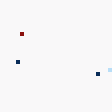

In [16]:
view_diff(perturbation[1, :, :, 1])

### `:PerturbedInput`

This is the perturbed image.

In [17]:
perturbed_input = getvalue(d1[:PerturbedInput])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

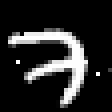

In [18]:
colorview(Gray, perturbed_input[1, :, :, 1])

We can verify that the perturbed input is in fact the sample image added to the perturbation.

In [19]:
all(perturbed_input == sample_image + perturbation)

true

### `:Output`

This is the calculated value of the activations of the final layer of the neural net with the perturbed input. Note that `output[10]` is (tied for) the largest element of the array, as we would expect with `tolerance=0`.

In [20]:
output = getvalue(d1[:Output])

10-element Array{Float64,1}:
 0.388105
 0.515855
 1.25875 
 0.296821
 0.410448
 0.556019
 0.444605
 3.49171 
 0.412949
 3.49171 

We can verify that these activations are indeed accurate:

In [21]:
perturbed_input |> n1params

10-element Array{Float64,1}:
 0.388105
 0.515855
 1.25875 
 0.296821
 0.410448
 0.556019
 0.444605
 3.49171 
 0.412949
 3.49171 

### `:BlurKernel`

An additional entry for the blur kernel is stored when we are searching over only blurring perturbations.

In [22]:
d_blur = MIPVerify.find_adversarial_example(n1params, sample_image, 10, GurobiSolver(OutputFlag=0),
    pp = MIPVerify.BlurPerturbationParameters((5, 5)))

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]


Dict{Symbol,Any} with 8 entries:
  :PerturbationParameters => blur.(5, 5)
  :TargetIndexes          => [10]
  :SolveStatus            => :Optimal
  :Output                 => JuMP.GenericAffExpr{Float64,JuMP.Variable}[-0.0120…
  :BlurKernel             => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …
  :Model                  => Minimization problem with:…
  :Perturbation           => JuMP.GenericAffExpr{Float64,JuMP.Variable}[__anon_…
  :PerturbedInput         => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …

In [24]:
getvalue(d_blur[:BlurKernel])

5×5×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0        0.0       0.0  0.0
 0.0  0.0        0.0       0.0  0.0
 0.0  0.0        0.351349  0.0  0.0
 0.0  0.0954499  0.256589  0.0  0.0
 0.0  0.296612   0.0       0.0  0.0